In [ ]:
!git clone https://github.com/bakhbyergyen7/FinalProject.git
%cd FinalProject/project_1_dataset
!ls

Cloning into 'FinalProject'...
remote: Enumerating objects: 27793, done.
remote: Counting objects: 100% (309/309), done.
remote: Compressing objects: 100% (251/251), done.
remote: Total 27793 (delta 173), reused 122 (delta 52), pack-reused 27484
Receiving objects: 100% (27793/27793), 47.26 MiB | 55.56 MiB/s, done.
Resolving deltas: 100% (177/177), done.
Updating files: 100% (28320/28320), done.
/content/FinalProject/project_1_dataset
test  train


In [ ]:
!ls test
!pip install tensorflow

angry  disgust	fear  happy  neutral  sad  surprise


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Lambda, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# Create a new input layer that accepts grayscale images
input_layer = Input(shape=(224, 224, 1))

# Use a Lambda layer to replicate the grayscale image across 3 channels
x = Lambda(lambda x: tf.tile(x, multiples=[1, 1, 1, 3]))(input_layer)

# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)

# Freeze the convolutional layers in the base model
base_model.trainable = False

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with 7 outputs (one for each emotion)
predictions = Dense(7, activation='softmax')(x)

# Create the new model
model = Model(inputs=input_layer, outputs=predictions)

# Set up the ModelCheckpoint callback to save the best model based on the validation accuracy
model_checkpoint_callback = ModelCheckpoint(
    'best_model.keras',  # Path where the model will be saved
    save_best_only=True,  # Save only the best model
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',  # Save the model with max validation accuracy
    verbose=1
)

# Set up the EarlyStopping callback to stop training if no improvement in validation accuracy
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=8,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

# Set up the ReduceLROnPlateau callback to reduce the learning rate when the validation accuracy plateaus
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.9,  # New learning rate will be lr * factor.
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=0.00001,  # Lower bound on the learning rate.
    verbose=1
)

# Define the directory for training data
train_directory = 'train'

# Load the training and validation data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    validation_split=0.2,  # Reserve 20% for validation
    subset="training",
    seed=123,  # Seed for reproducibility
    image_size=(224, 224),
    batch_size=64,
    color_mode='grayscale',  # Images are grayscale
    label_mode='categorical'  # Labels are categorical
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    validation_split=0.2, # Reserve 20% for validation
    subset="validation",
    seed=123, # Seed for reproducibility
    image_size=(224, 224),
    batch_size=64,
    color_mode='grayscale', # Images are grayscale
    label_mode='categorical' # Labels are categorical
)


test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    image_size=(224, 224),
    batch_size=64,
    color_mode='grayscale', # Images are grayscale
    label_mode='categorical' # Labels are categorical
)

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model with the optimizer and loss and accuracy metrics
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with callbacks
history = model.fit(
    train_data,
    epochs=100,
    validation_data=validation_data,  # Use the validation data generator here
    callbacks=[
        model_checkpoint_callback,
        early_stopping_callback,
        reduce_lr_callback
    ]
)

# Evaluate the model on the test data
evaluation = model.evaluate(test_data)
print("Test Loss:", evaluation[0], "Test Accuracy:", evaluation[1])

94765736/94765736 [==============================] - 0s 0us/step
Found 20634 files belonging to 7 classes.
Using 16508 files for training.
Found 20634 files belonging to 7 classes.
Using 4126 files for validation.
Found 5155 files belonging to 7 classes.
Epoch 1/100
109/129 [========================>.....] - ETA: 42s - loss: 1.8880 - accuracy: 0.2705

KeyboardInterrupt: 

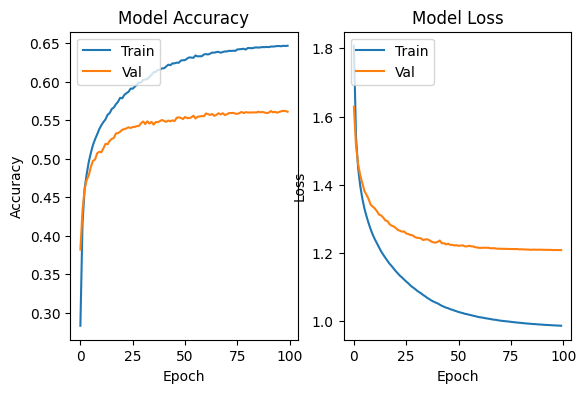

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training & validation accuracy values
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

In [ ]:
#  Load the model and test it out


from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/FinalProject/project_1_dataset/FinalProject/project_1_dataset/best_model.keras')

# Use the loaded model for predictions or evaluation
predictions = model.predict(test_data)
evaluation = model.evaluate(test_data)
print("Test Loss:", evaluation[0], "Test Accuracy:", evaluation[1])